In [5]:
import psycopg2
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns

connct = psycopg2.connect('dbname=WhiskyAdvocate user= postgres password = [redacted] host = 127.0.0.1 port=5432')

#Query the database to recover the needed data for unsupervised learning operations

ds_query = ''' SELECT whiskey_stats.price_usd, whiskey_stats.percent_abv, features_rev.*
                FROM whiskey_stats
                INNER JOIN features_rev
                ON whiskey_stats.whiskey_id = features_rev.whiskey_id;'''

ml_df_full = pd.read_sql(ds_query, connct)

ml_df_full.head()

price_usd  percent_abv  fruity_words  wood_words  spicy_words  sweet_words  \
0       55.0         45.0             2           1            2            0   
1       40.0         40.0             2           0            0            1   
2       40.0         50.0             1           2            1            1   
3       35.0         45.2             1           0            0            3   
4       65.0         45.0             2           0            0            3   

   maillard_words  smoke_words  sherry  white  hot  bitter  complex  subtle  \
0               0            0       0      0    0       0        0       0   
1               2            0       0      0    0       0        0       0   
2               1            0       0      0    0       0        0       0   
3               0            0       0      0    0       0        0       0   
4               1            0       0      0    0       0        0       0   

   floral  whiskey_id  
0       1           0  
1       0           1  
2       0           2  
3       0           3  
4       0           4

In [3]:
#connct.close()

I am choosing DBSCAN for clustering analysis because there are a lot of points that look like noise points, and a lot of the points look like noise points. Kmeans and agglomerative clustering are bad for irregular shaped clusters. 

In [6]:
#git rid of whiskey_id

ml_df = ml_df_full.drop(['whiskey_id'], axis = 1)

#check for missing values
ml_df.isnull().sum()

price_usd         0
percent_abv       0
fruity_words      0
wood_words        0
spicy_words       0
sweet_words       0
maillard_words    0
smoke_words       0
sherry            0
white             0
hot               0
bitter            0
complex           0
subtle            0
floral            0
dtype: int64

In [7]:
ml_df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 5900 entries, 0 to 5899
Data columns (total 15 columns):
 #   Column          Non-Null Count  Dtype  
---  ------          --------------  -----  
 0   price_usd       5900 non-null   float64
 1   percent_abv     5900 non-null   float64
 2   fruity_words    5900 non-null   int64  
 3   wood_words      5900 non-null   int64  
 4   spicy_words     5900 non-null   int64  
 5   sweet_words     5900 non-null   int64  
 6   maillard_words  5900 non-null   int64  
 7   smoke_words     5900 non-null   int64  
 8   sherry          5900 non-null   int64  
 9   white           5900 non-null   int64  
 10  hot             5900 non-null   int64  
 11  bitter          5900 non-null   int64  
 12  complex         5900 non-null   int64  
 13  subtle          5900 non-null   int64  
 14  floral          5900 non-null   int64  
dtypes: float64(2), int64(13)
memory usage: 691.5 KB


I am going to try implementing the DBSCAN clustering alogrythm using scikit learn. I have questions about how well it will work. If it doesn't work, I don't think other clustering algorythms are necessarily likely to work better because of the irregular appearance of some of the clusters when I run t-SNE. An idea I have for refactoring the project is to combine features that seem related - for instance sugar, sweet and honey could all go in the same features, and some of the fruit descriptors could be summed in another feature. This reduceds the dimensionality of the feature space along defensible lines, and may make it easier to spot clusters and patterns.  

In [8]:
#import some necessary things from sklearn

import sklearn
from sklearn.manifold import TSNE
from sklearn.preprocessing import MinMaxScaler
from sklearn.cluster import DBSCAN


In [9]:
#scale the data using minmaxscaler

scaler = MinMaxScaler().fit(ml_df)

ml_scale = scaler.transform(ml_df)

ml_scale

array([[3.02562224e-04, 4.45151033e-01, 1.81818182e-01, ...,
        0.00000000e+00, 0.00000000e+00, 5.00000000e-01],
       [2.07016259e-04, 3.65659777e-01, 1.81818182e-01, ...,
        0.00000000e+00, 0.00000000e+00, 0.00000000e+00],
       [2.07016259e-04, 5.24642289e-01, 9.09090909e-02, ...,
        0.00000000e+00, 0.00000000e+00, 0.00000000e+00],
       ...,
       [2.70713569e-04, 4.45151033e-01, 9.09090909e-02, ...,
        0.00000000e+00, 0.00000000e+00, 0.00000000e+00],
       [5.25502811e-04, 5.64387917e-01, 9.09090909e-02, ...,
        0.00000000e+00, 0.00000000e+00, 0.00000000e+00],
       [2.07016259e-04, 4.13354531e-01, 1.81818182e-01, ...,
        0.00000000e+00, 0.00000000e+00, 0.00000000e+00]])

In [10]:
#I used min max scaler, which should put all the features between 0 and 1. this means my epsilon (neighborhood) value for 
#DBSCAN needs to be small. I'm going to start with 0.05
#min samples should be kind of large because there are 5900 points in the set. 25 seems like a reasonable value to start. 

cls_1 = DBSCAN(eps = 0.05, min_samples = 25).fit_predict(ml_scale)

cls_1

array([-1, -1, -1, ..., -1, -1, -1], dtype=int64)

In [11]:
# my preferred t-SNE parameters were tsne15 = TSNE(random_state=42, perplexity = 40, learning_rate = 1000)
#copying over my helpful t-SNE functions for visualizing my clustering

def tsne_unpack(tsne_array, list1, list2):
    for t in tsne_array:
        list1.append(t[0])
        list2.append(t[1])

def visny_tsne(tsne_instantiation):
    
    ws_tsne_iter = tsne_instantiation.fit_transform(ml_scale)
    
    tsne_x = []
    tsne_y = []
    
    tsne_unpack(ws_tsne_iter, tsne_x, tsne_y)
    
    plt.figure(figsize = (12, 12))
    sns.scatterplot(x = tsne_x, y = tsne_y)
    plt.show()


In [12]:
#constructing a dataframe for t-SNE visualization of clustering
pref_tsne = TSNE(random_state=42, perplexity = 50, learning_rate = 1000, early_exaggeration = 20)

db_tsne1 = pref_tsne.fit_transform(ml_scale)

pref_tsne_x = []
pref_tsne_y = []

tsne_unpack(db_tsne1, pref_tsne_x, pref_tsne_y)

vis1_dict = {'tSNE_x': pref_tsne_x, 'tSNE_y':pref_tsne_y}

vis_1 = pd.DataFrame(vis1_dict)

vis_1.head()

tSNE_x     tSNE_y
0  74.764534 -37.924046
1 -11.578444   3.540999
2  -6.683891  22.993643
3  13.254317 -17.626324
4  12.341535 -17.313374

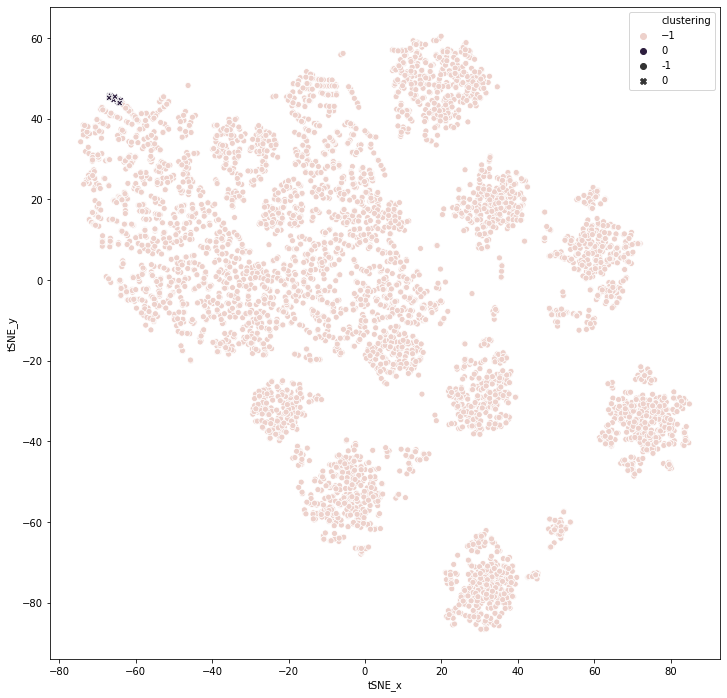

In [27]:
# adding clustering data as a new column, and visualizing

vis_1['clustering'] = cls_1

plt.figure(figsize = (12, 12))
sns.scatterplot(data = vis_1, x = 'tSNE_x', y = 'tSNE_y', hue = 'clustering', style = 'clustering')

plt.show()

This is clearly not the set of conditions for this dataset. 

In [14]:
# I am going to use the elbow method for deciding my epsilon value
# I used a similar method to Chelsea Pelleriti https://www.youtube.com/watch?v=0V2r7SGP2ZM

from sklearn.neighbors import NearestNeighbors

#set mins argument (what distance do you want nearest neighbors to go by)
# I will start with 25 but may reduce this number
mins = 25

nn = NearestNeighbors(mins + 1)

nn.fit(ml_scale)

distances, neighbors = nn.kneighbors(ml_scale)

distances

C:\Users\gspah\anaconda3\lib\site-packages\sklearn\utils\validation.py:68: FutureWarning: Pass n_neighbors=26 as keyword args. From version 0.25 passing these as positional arguments will result in an error
  warnings.warn("Pass {} as keyword args. From version 0.25 "


array([[0.        , 0.01589854, 0.09631036, ..., 0.24080305, 0.24080308,
        0.24347595],
       [0.        , 0.09090909, 0.09090914, ..., 0.18162771, 0.18162772,
        0.18162788],
       [0.        , 0.02384738, 0.04134183, ..., 0.14813461, 0.14813463,
        0.14813472],
       ...,
       [0.        , 0.01589866, 0.09229372, ..., 0.16322364, 0.16736416,
        0.16967291],
       [0.        , 0.33045508, 0.36665964, ..., 0.41424943, 0.41438961,
        0.41648197],
       [0.        , 0.20442425, 0.22292124, ..., 0.35600016, 0.35600019,
        0.35600036]])

In [15]:
len(distances)

5900

In [16]:
distances = np.sort(distances[:, mins], axis = 0)

distances

array([0.04769561, 0.04769561, 0.04769582, ..., 0.99744842, 0.99922541,
       1.01414875])

In [17]:
len(distances)

5900

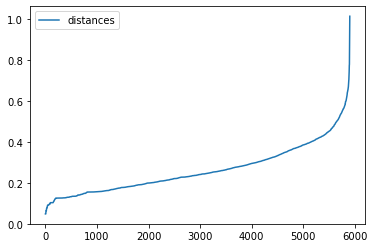

In [18]:
distance_df = pd.DataFrame({'distances':distances})

distance_df.plot(kind = 'line')

C:\Users\gspah\anaconda3\lib\site-packages\sklearn\utils\validation.py:68: FutureWarning: Pass n_neighbors=26 as keyword args. From version 0.25 passing these as positional arguments will result in an error
  warnings.warn("Pass {} as keyword args. From version 0.25 "


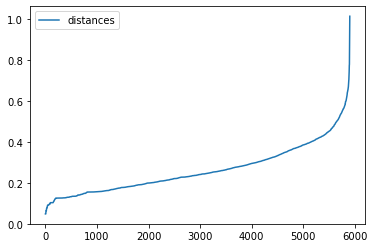

In [19]:
#code out a function to look at how this works for a few different values of mins

def elbow_fxn(min_nearest_neighbors):
    nns = NearestNeighbors(min_nearest_neighbors + 1)
    nns.fit(ml_scale)
    dist, neigh = nns.kneighbors(ml_scale)
    dist = np.sort(dist[:, min_nearest_neighbors], axis = 0)
    dist_df = pd.DataFrame({'distances': dist})
    dist_df.plot(kind = 'line')
    plt.show()

elbow_fxn(25)


C:\Users\gspah\anaconda3\lib\site-packages\sklearn\utils\validation.py:68: FutureWarning: Pass n_neighbors=11 as keyword args. From version 0.25 passing these as positional arguments will result in an error
  warnings.warn("Pass {} as keyword args. From version 0.25 "


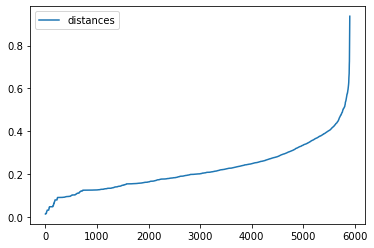

In [40]:
elbow_fxn(10)

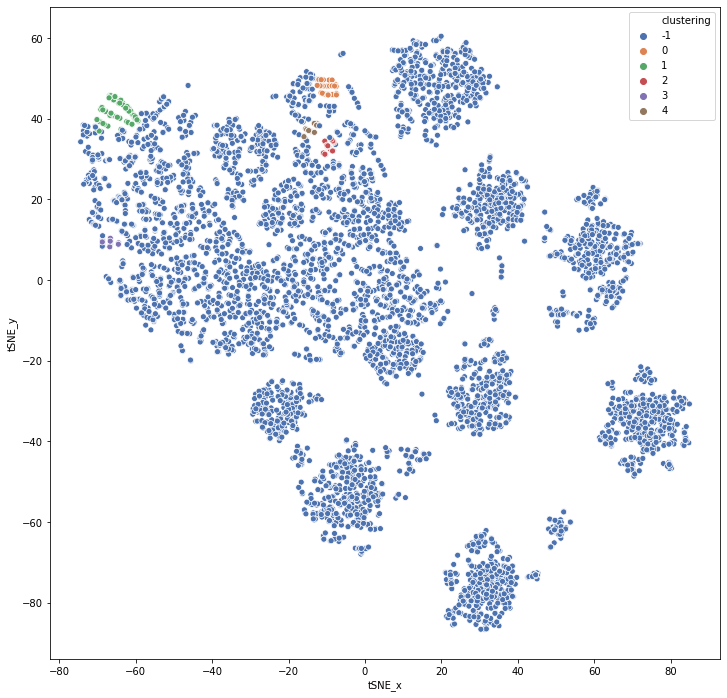

In [31]:
#elbow function is different, but still not sure I've got it right. I'm going to try a few new values for clustering (again) though, 
#based on the scales I'm seeing. 

cls_2 = DBSCAN(eps = 0.1, min_samples = 25).fit_predict(ml_scale)

#write a function to make visualizing clustering results on the t-SNE picture really easy

def cluster_vis(dbscan_array):
    vis_1['clustering'] = dbscan_array

    plt.figure(figsize = (12, 12))
    sns.scatterplot(data = vis_1, x = 'tSNE_x', y = 'tSNE_y', hue = 'clustering', palette = 'deep')

    plt.show()

cluster_vis(cls_2)
    

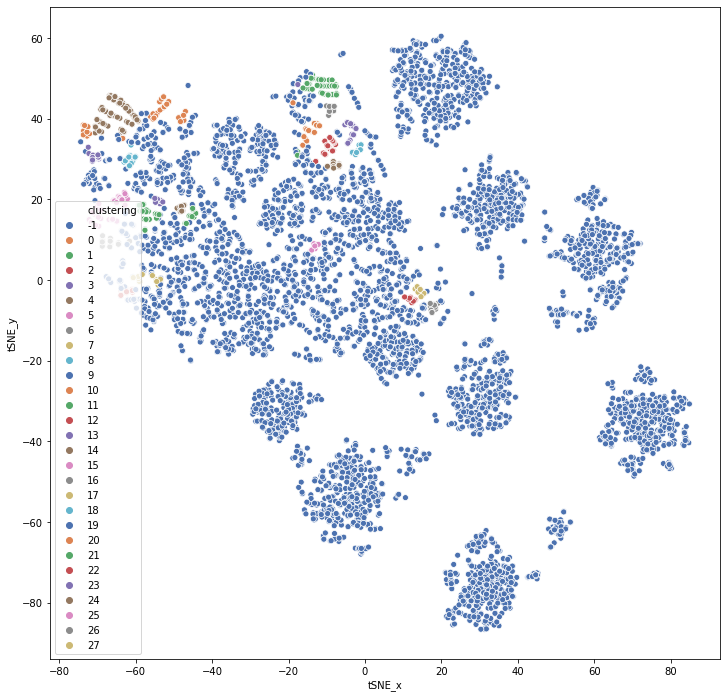

In [32]:
cls_3  = DBSCAN(eps = 0.1, min_samples = 10).fit_predict(ml_scale) 

cluster_vis(cls_3)

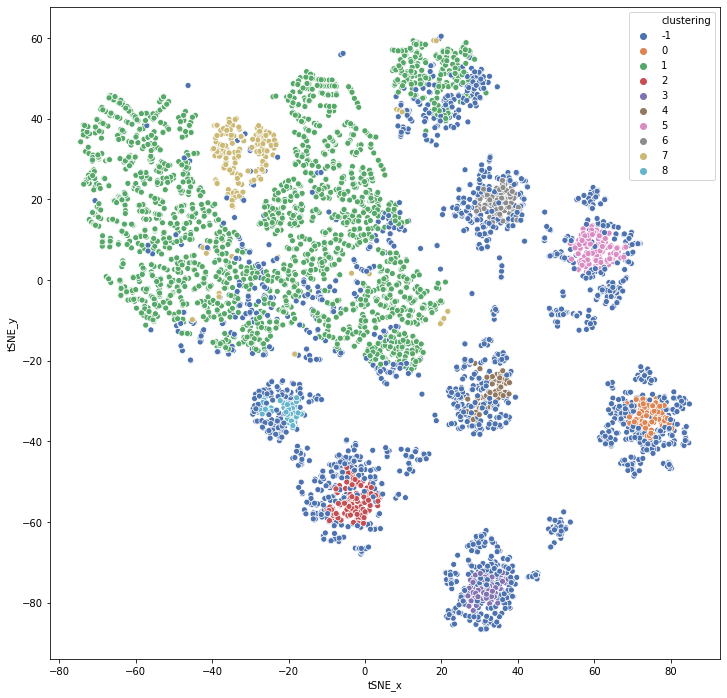

In [33]:
cls_4 = DBSCAN(eps = 0.2, min_samples = 10).fit_predict(ml_scale)

cluster_vis(cls_4)

This looks like what I want to see. I'm going to try a few other conditions and come back to this one if they aren't an improvement

In [51]:
#set up silhouette score
from sklearn.metrics import silhouette_score

print(f'silhouette score w noise{silhouette_score(ml_scale, cls_4)}')



silhouette score w noise-0.05073008431046391


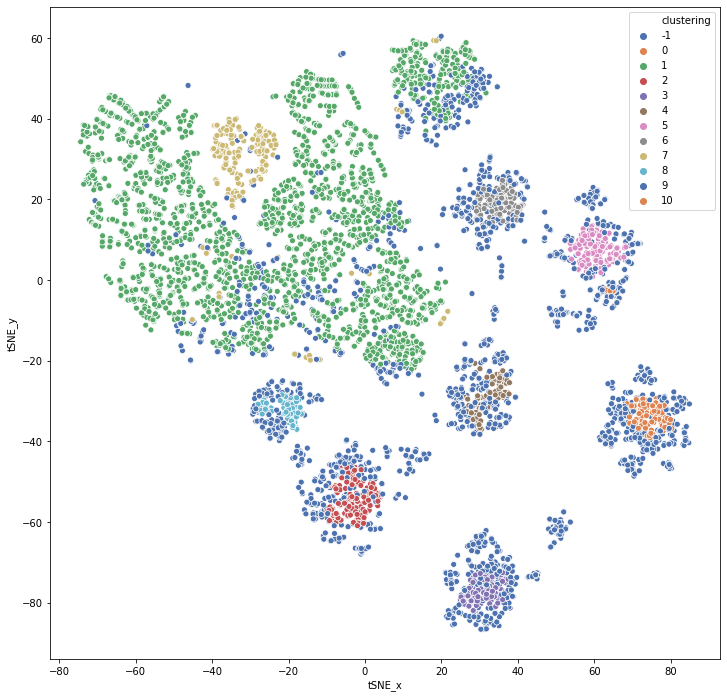

In [34]:
cls_5 = DBSCAN(eps = 0.2, min_samples = 8).fit_predict(ml_scale)

cluster_vis(cls_5)

In [52]:
print(f'silhouette score w noise{silhouette_score(ml_scale, cls_5)}')

silhouette score w noise-0.050782583838923104


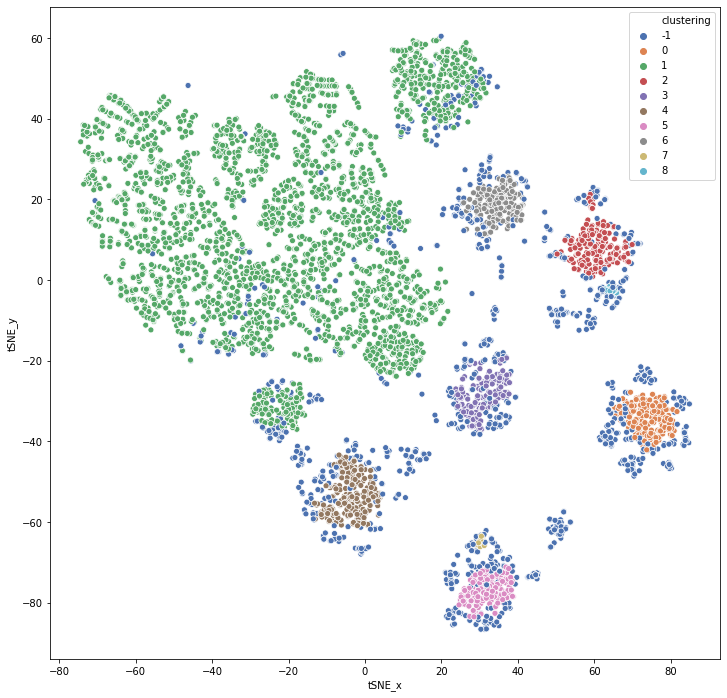

In [53]:
cls_61 = DBSCAN(eps = 0.25, min_samples = 10).fit_predict(ml_scale)

cluster_vis(cls_61)

In [55]:
print(f'silhouette score w noise {silhouette_score(ml_scale, cls_61)}')

silhouette score w noise 0.07336862386232387


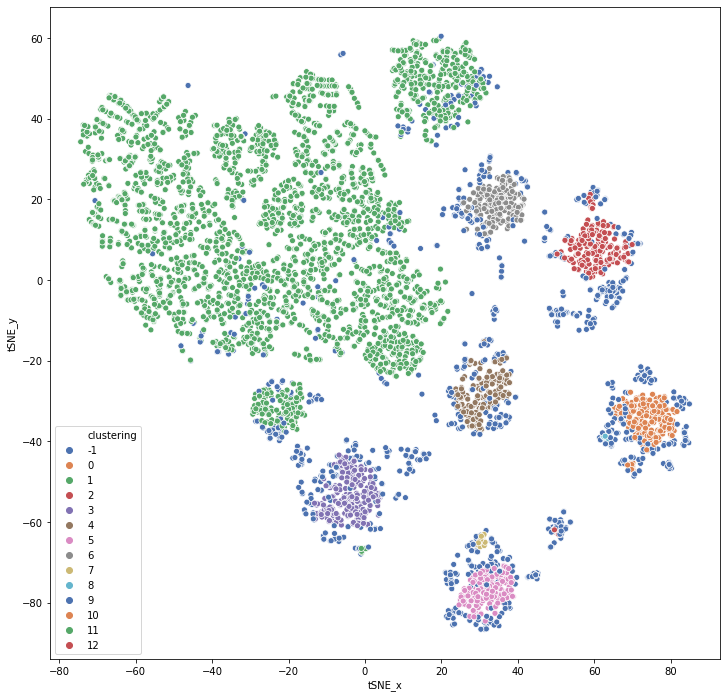

In [36]:
cls_6 = DBSCAN(eps = 0.25, min_samples = 8).fit_predict(ml_scale)

cluster_vis(cls_6)

In [56]:
print(f'silhouette score w noise {silhouette_score(ml_scale, cls_6)}')

silhouette score w noise 0.0641520154575718


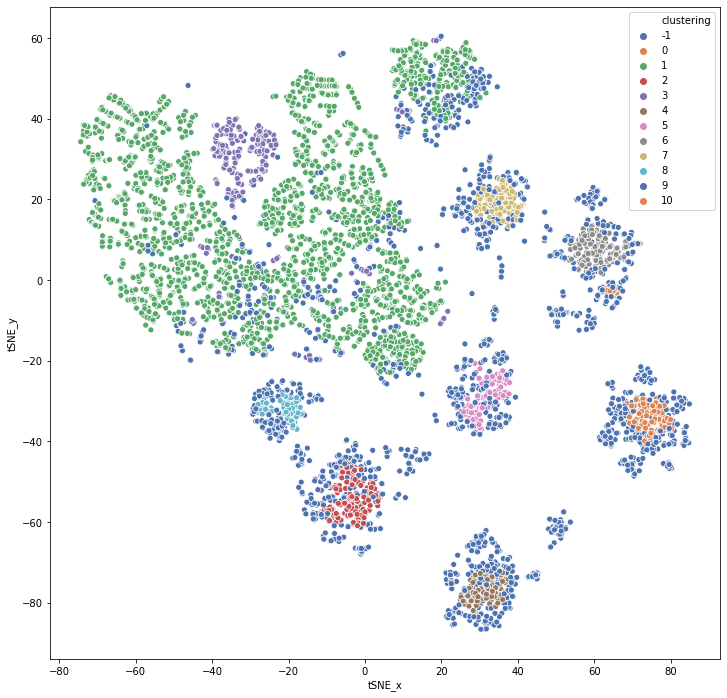

In [37]:
cls_7 = DBSCAN(eps = 0.2, min_samples = 7).fit_predict(ml_scale)

cluster_vis(cls_7)

In [57]:
print(f'silhouette score w noise {silhouette_score(ml_scale, cls_7)}')

silhouette score w noise -0.04463389031870189


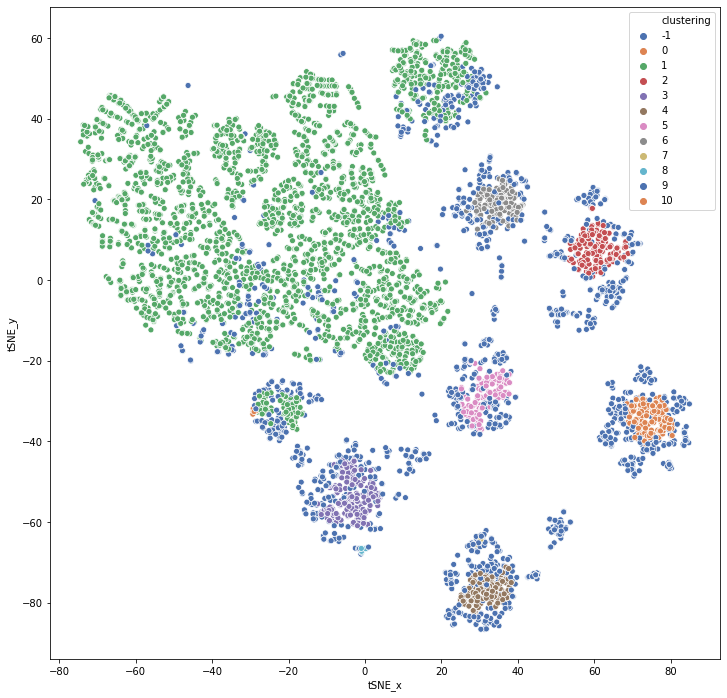

In [38]:
cls_8 = DBSCAN(eps = 0.21, min_samples = 7).fit_predict(ml_scale)

cluster_vis(cls_8)

In [58]:
print(f'silhouette score w noise {silhouette_score(ml_scale, cls_8)}')

silhouette score w noise 0.01905088108849306


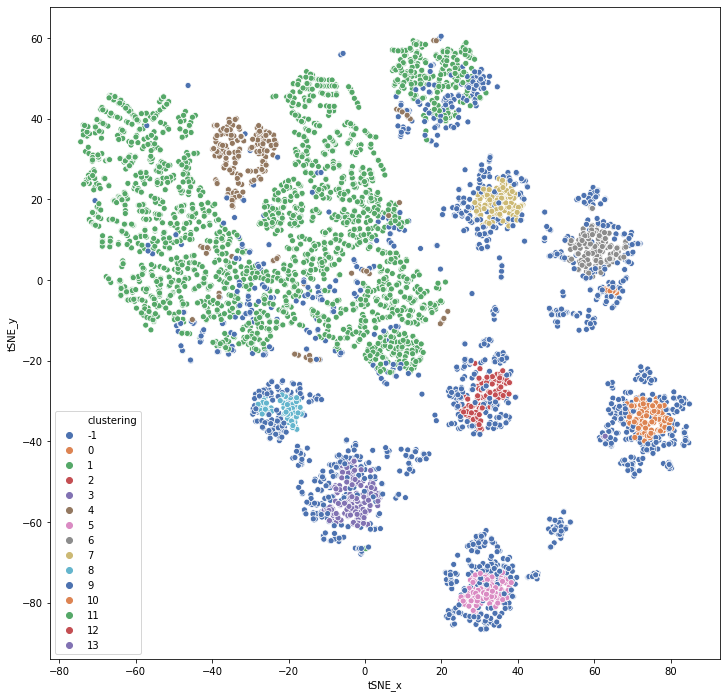

In [39]:
cls_9 = DBSCAN(eps = 0.2, min_samples = 6).fit_predict(ml_scale)

cluster_vis(cls_9)

In [59]:
print(f'silhouette score w noise {silhouette_score(ml_scale, cls_9)}')

silhouette score w noise -0.049697681213313465


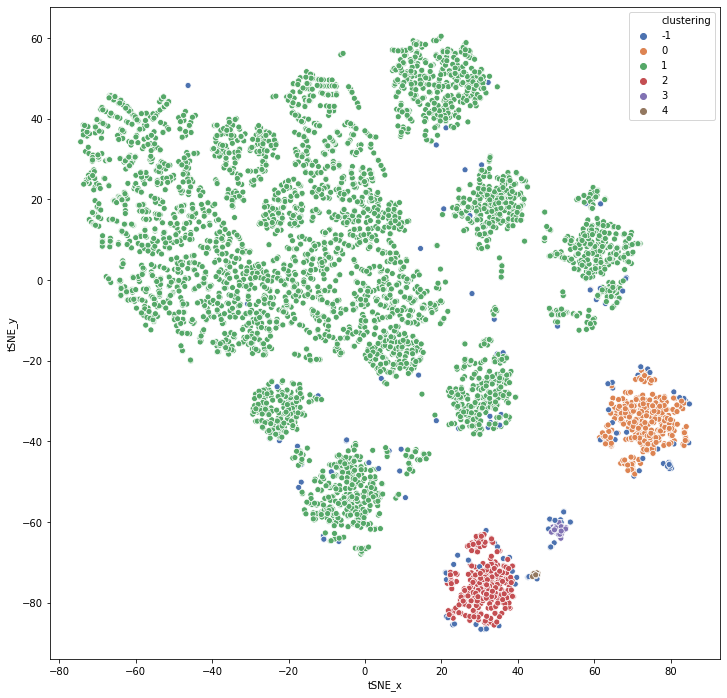

In [41]:
cls_10 = DBSCAN(eps = 0.4, min_samples = 10).fit_predict(ml_scale)

cluster_vis(cls_10)

In [60]:
print(f'silhouette score w noise {silhouette_score(ml_scale, cls_10)}')

silhouette score w noise 0.2311088212802517


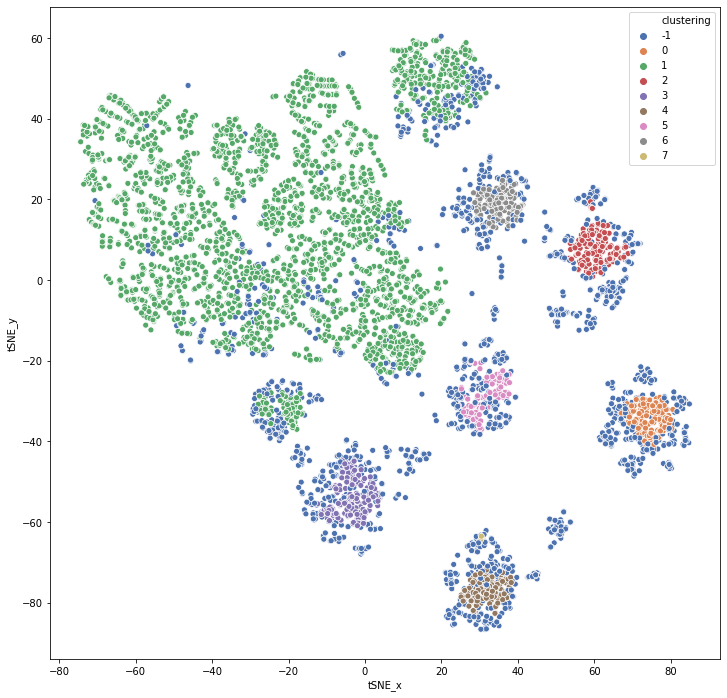

In [42]:
cls_11 = DBSCAN(eps = 0.22, min_samples = 10).fit_predict(ml_scale)

cluster_vis(cls_11)

In [61]:
print(f'silhouette score w noise {silhouette_score(ml_scale, cls_11)}')

silhouette score w noise 0.041995064422409766


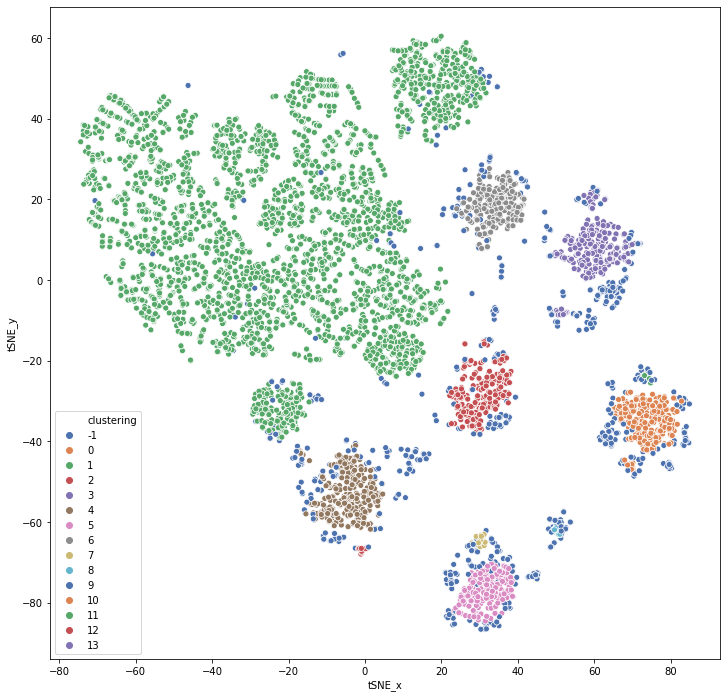

In [43]:
cls_12 = DBSCAN(eps = 0.3, min_samples = 10).fit_predict(ml_scale)

cluster_vis(cls_12)

In [62]:
print(f'silhouette score w noise {silhouette_score(ml_scale, cls_12)}')

silhouette score w noise 0.08863111993132665


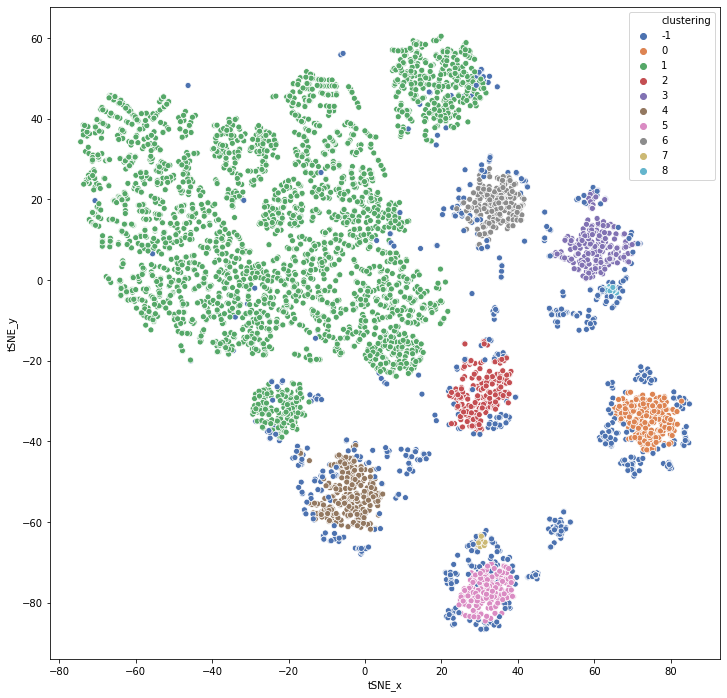

In [44]:
cls_13 = DBSCAN(eps = 0.3, min_samples = 15).fit_predict(ml_scale)

cluster_vis(cls_13)

In [63]:
print(f'silhouette score w noise {silhouette_score(ml_scale, cls_13)}')

silhouette score w noise 0.09778192721089207


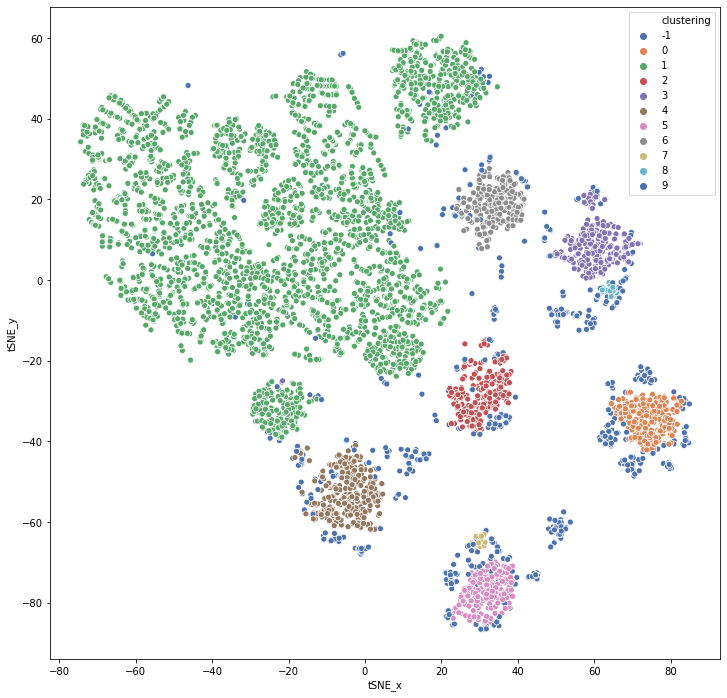

In [45]:
cls_14 = DBSCAN(eps = 0.33, min_samples = 15).fit_predict(ml_scale)

cluster_vis(cls_14)

In [64]:
print(f'silhouette score w noise {silhouette_score(ml_scale, cls_14)}')

silhouette score w noise 0.10441930224738478


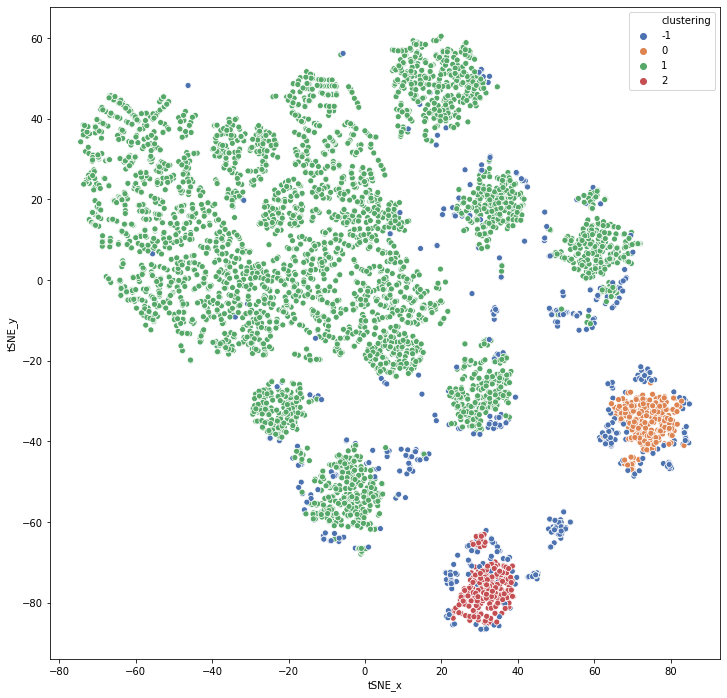

In [66]:
cls_15 = DBSCAN(eps = 0.34, min_samples = 15).fit_predict(ml_scale)

cluster_vis(cls_15)

In [67]:
print(f'silhouette score w noise {silhouette_score(ml_scale, cls_15)}')

silhouette score w noise 0.20780671766437103


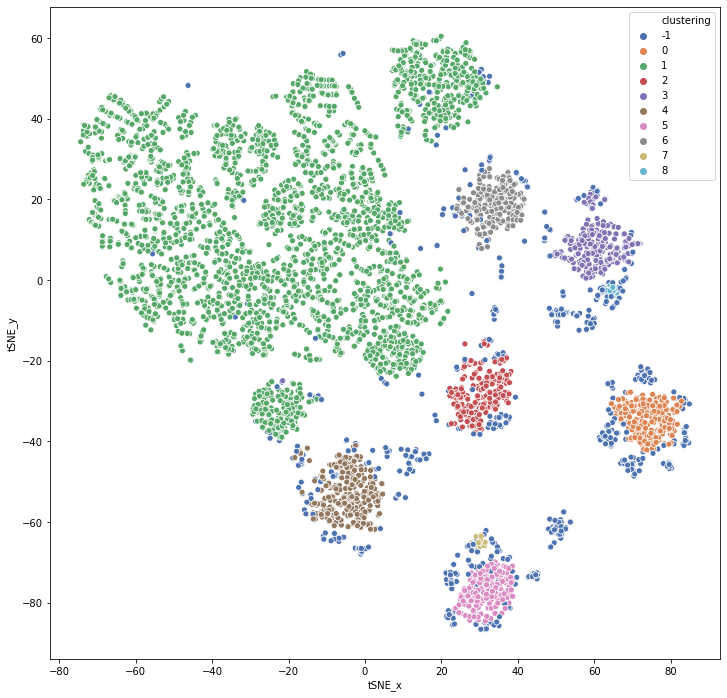

In [68]:
cls_16 = DBSCAN(eps = 0.33, min_samples = 20).fit_predict(ml_scale)

cluster_vis(cls_16)

In [69]:
print(f'silhouette score w noise {silhouette_score(ml_scale, cls_16)}')

silhouette score w noise 0.10769464103894406


In [70]:
#I am going to try to extract some meaning from cls_16

ml_df_full['clustering'] = cls_16

ml_df_full.head()

price_usd  percent_abv  fruity_words  wood_words  spicy_words  sweet_words  \
0       55.0         45.0             2           1            2            0   
1       40.0         40.0             2           0            0            1   
2       40.0         50.0             1           2            1            1   
3       35.0         45.2             1           0            0            3   
4       65.0         45.0             2           0            0            3   

   maillard_words  smoke_words  sherry  white  hot  bitter  complex  subtle  \
0               0            0       0      0    0       0        0       0   
1               2            0       0      0    0       0        0       0   
2               1            0       0      0    0       0        0       0   
3               0            0       0      0    0       0        0       0   
4               1            0       0      0    0       0        0       0   

   floral  whiskey_id  clustering  
0       1           0           0  
1       0           1           1  
2       0           2           1  
3       0           3           1  
4       0           4           1

In [71]:
cluster_medians = ml_df_full.groupby('clustering').median()

cluster_medians

price_usd  percent_abv  fruity_words  wood_words  spicy_words  \
clustering                                                                  
-1               79.0        46.00           1.0         1.0          1.0   
 0               65.0        46.00           1.0         1.0          1.0   
 1               80.0        46.00           1.0         1.0          1.0   
 2               73.0        46.00           2.0         1.0          1.0   
 3               60.0        46.00           1.0         1.0          1.0   
 4               68.0        46.00           1.0         1.0          1.0   
 5               72.5        46.00           1.0         1.0          1.0   
 6              100.0        46.25           1.0         1.0          1.0   
 7               95.0        45.65           1.0         1.0          1.0   
 8               36.0        45.00           0.0         1.0          1.0   

            sweet_words  maillard_words  smoke_words  sherry  white  hot  \
clustering                                                                 
-1                  1.0             1.0          0.0     0.0    0.0  0.0   
 0                  1.0             1.0          0.0     0.0    0.0  0.0   
 1                  1.0             1.0          0.0     0.0    0.0  0.0   
 2                  1.0             1.0          0.0     0.0    0.0  0.0   
 3                  1.0             0.0          0.0     0.0    0.0  1.0   
 4                  1.0             1.0          0.0     0.0    1.0  0.0   
 5                  1.0             1.0          0.0     0.0    0.0  0.0   
 6                  1.0             1.0          0.0     0.0    0.0  0.0   
 7                  0.0             1.0          0.0     0.0    0.0  0.0   
 8                  1.0             0.0          0.0     0.0    0.0  2.0   

            bitter  complex  subtle  floral  whiskey_id  
clustering                                               
-1             0.0      0.0     0.0     0.0      2883.0  
 0             0.0      0.0     0.0     1.0      3195.0  
 1             0.0      0.0     0.0     0.0      3030.0  
 2             1.0      0.0     0.0     0.0      2388.0  
 3             0.0      0.0     0.0     0.0      2193.0  
 4             0.0      0.0     0.0     0.0      3078.5  
 5             0.0      0.0     1.0     0.0      3564.0  
 6             0.0      1.0     0.0     0.0      3047.0  
 7             0.0      1.0     1.0     0.0      3647.0  
 8             0.0      0.0     0.0     0.0      2136.0

Here is what it looks like the differences are based on medians:<br>
Noise: these are well rounded whiskeys that average 1 of each word category except smoke, but none of the novel words<br>
0: these cluster away from noise because they are described as floral<br>
1: no indication of how these are different from noise. Most of the whiskeys live here (3709/5900)<br>
2: median 2 fruity words, often described as 'bitter'<br>
3: No maillard words, described as 'hot'<br>
4: described as 'white'<br>
5: described as 'subtle'<br>
6: described as 'complex', median price is high, median sweet words is zero<br>
7: described as 'complex' and 'subtle' median price is high<br>
8: described as 'hot' more than once, no fruity or maillard words<br>

In [73]:
cluster_means = ml_df_full.groupby('clustering').mean()

cluster_means

price_usd  percent_abv  fruity_words  wood_words  spicy_words  \
clustering                                                                    
-1           947.662182    47.487309      1.423019    1.411061     1.565022   
 0           345.717742    46.832056      1.467742    1.233871     0.975806   
 1           298.778377    47.797273      1.303855    1.112968     1.176597   
 2           499.012876    47.890558      1.656652    1.051502     1.236052   
 3           109.049020    48.309804      0.862745    1.007843     1.180392   
 4           353.906897    46.453414      1.393103    1.155172     1.503448   
 5           392.665179    47.808929      1.178571    1.316964     1.214286   
 6           297.149123    48.959956      1.153509    1.157895     1.052632   
 7          1898.636364    46.597727      1.409091    1.090909     1.227273   
 8            47.636364    46.850000      0.136364    1.409091     1.000000   

            sweet_words  maillard_words  smoke_words    sherry     white  \
clustering                                                                 
-1             1.095665        1.242152     0.548580  0.319880  0.370703   
 0             0.870968        0.870968     0.112903  0.137097  0.000000   
 1             0.798598        1.059854     0.379887  0.199515  0.000000   
 2             0.776824        1.287554     0.158798  0.154506  0.000000   
 3             1.027451        0.635294     0.309804  0.031373  0.000000   
 4             0.844828        1.141379     0.179310  0.100000  1.000000   
 5             0.763393        0.959821     0.379464  0.093750  0.000000   
 6             0.662281        1.109649     0.285088  0.153509  0.000000   
 7             0.181818        1.090909     0.181818  0.045455  0.000000   
 8             0.954545        0.500000     0.045455  0.045455  0.000000   

                 hot    bitter   complex    subtle    floral   whiskey_id  
clustering                                                                 
-1          0.328849  0.310912  0.276532  0.258595  0.292975  2904.573991  
 0          0.000000  0.000000  0.000000  0.000000  1.000000  3055.169355  
 1          0.000000  0.000000  0.000000  0.000000  0.000000  2999.546508  
 2          0.000000  1.000000  0.000000  0.000000  0.000000  2524.592275  
 3          1.000000  0.000000  0.000000  0.000000  0.000000  2612.070588  
 4          0.000000  0.000000  0.000000  0.000000  0.000000  2940.351724  
 5          0.000000  0.000000  0.000000  1.000000  0.000000  3189.232143  
 6          0.000000  0.000000  1.000000  0.000000  0.000000  2841.390351  
 7          0.000000  0.000000  1.000000  1.000000  0.000000  2766.136364  
 8          2.000000  0.000000  0.000000  0.000000  0.000000  2081.818182

In [75]:
cluster_counts = ml_df_full.groupby('clustering').count()

cluster_counts

price_usd  percent_abv  fruity_words  wood_words  spicy_words  \
clustering                                                                  
-1                669          669           669         669          669   
 0                248          248           248         248          248   
 1               3709         3709          3709        3709         3709   
 2                233          233           233         233          233   
 3                255          255           255         255          255   
 4                290          290           290         290          290   
 5                224          224           224         224          224   
 6                228          228           228         228          228   
 7                 22           22            22          22           22   
 8                 22           22            22          22           22   

            sweet_words  maillard_words  smoke_words  sherry  white   hot  \
clustering                                                                  
-1                  669             669          669     669    669   669   
 0                  248             248          248     248    248   248   
 1                 3709            3709         3709    3709   3709  3709   
 2                  233             233          233     233    233   233   
 3                  255             255          255     255    255   255   
 4                  290             290          290     290    290   290   
 5                  224             224          224     224    224   224   
 6                  228             228          228     228    228   228   
 7                   22              22           22      22     22    22   
 8                   22              22           22      22     22    22   

            bitter  complex  subtle  floral  whiskey_id  
clustering                                               
-1             669      669     669     669         669  
 0             248      248     248     248         248  
 1            3709     3709    3709    3709        3709  
 2             233      233     233     233         233  
 3             255      255     255     255         255  
 4             290      290     290     290         290  
 5             224      224     224     224         224  
 6             228      228     228     228         228  
 7              22       22      22      22          22  
 8              22       22      22      22          22

In [78]:
#bring in names

ds_query2 = ''' SELECT whiskey_stats.name
                FROM whiskey_stats
                '''

names = pd.read_sql(ds_query2, connct)

names.head()

name
0  Spirit Hound Single Barrel Straight Malt (Barr...
1                     Dogfish Head Straight Malt 40%
2      Balcones Texas Bock Straight Malt Whiskey 50%
3       Woodford Reserve Straight Malt Whiskey 45.2%
4  Spirit Hound Colorado Honey Malt (Barrel No. 4...

In [79]:
ml_df_full['names'] = names['name']

ml_df_full.head()

price_usd  percent_abv  fruity_words  wood_words  spicy_words  sweet_words  \
0       55.0         45.0             2           1            2            0   
1       40.0         40.0             2           0            0            1   
2       40.0         50.0             1           2            1            1   
3       35.0         45.2             1           0            0            3   
4       65.0         45.0             2           0            0            3   

   maillard_words  smoke_words  sherry  white  hot  bitter  complex  subtle  \
0               0            0       0      0    0       0        0       0   
1               2            0       0      0    0       0        0       0   
2               1            0       0      0    0       0        0       0   
3               0            0       0      0    0       0        0       0   
4               1            0       0      0    0       0        0       0   

   floral  whiskey_id  clustering  \
0       1           0           0   
1       0           1           1   
2       0           2           1   
3       0           3           1   
4       0           4           1   

                                               names  
0  Spirit Hound Single Barrel Straight Malt (Barr...  
1                     Dogfish Head Straight Malt 40%  
2      Balcones Texas Bock Straight Malt Whiskey 50%  
3       Woodford Reserve Straight Malt Whiskey 45.2%  
4  Spirit Hound Colorado Honey Malt (Barrel No. 4...

In [92]:
c8 = ml_df_full[ml_df_full['clustering'] == 8]

#c8.head()

In [93]:
c7 = ml_df_full[ml_df_full['clustering'] == 7]

#c7.head()

In [94]:
c6 = ml_df_full[ml_df_full['clustering'] == 6]

#c6.head()

In [95]:
c5 = ml_df_full[ml_df_full['clustering'] == 5]

#c5.head()

In [96]:
c4 = ml_df_full[ml_df_full['clustering'] == 4]

#c4.head()

In [97]:
c3 = ml_df_full[ml_df_full['clustering'] == 3]

#c3.head()

In [98]:
c2 = ml_df_full[ml_df_full['clustering'] == 2]

#c2.head()

In [99]:
c1 = ml_df_full[ml_df_full['clustering'] == 1]

#c1.head()

In [100]:
c0 = ml_df_full[ml_df_full['clustering'] == 0]

#c0.head()

# Visualize differences in the Flavor Words and Prices

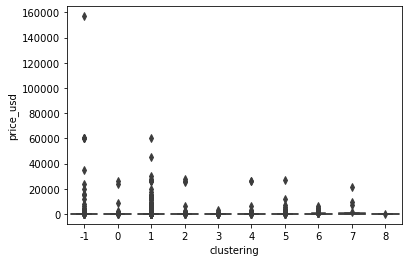

In [102]:
sns.boxplot(x = 'clustering', y = 'price_usd', data = ml_df_full )
plt.show()

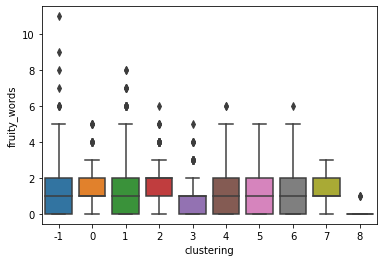

In [103]:
sns.boxplot(x = 'clustering', y = 'fruity_words', data = ml_df_full )
plt.show()

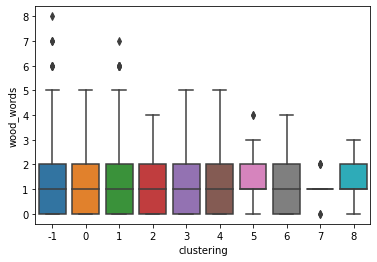

In [104]:
sns.boxplot(x = 'clustering', y = 'wood_words', data = ml_df_full )
plt.show()

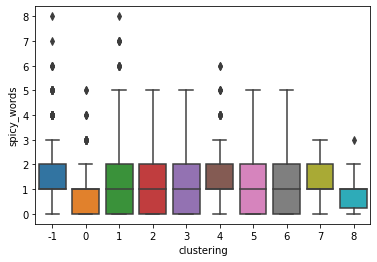

In [105]:
sns.boxplot(x = 'clustering', y = 'spicy_words', data = ml_df_full )
plt.show()

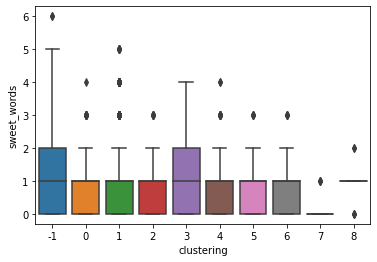

In [106]:
sns.boxplot(x = 'clustering', y = 'sweet_words', data = ml_df_full )
plt.show()

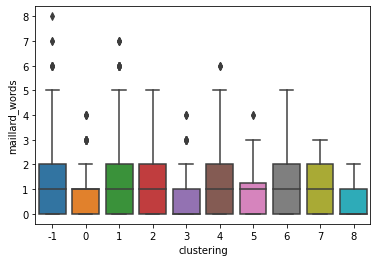

In [107]:
sns.boxplot(x = 'clustering', y = 'maillard_words', data = ml_df_full )
plt.show()

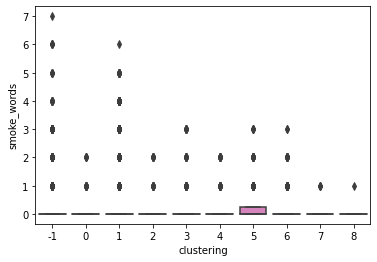

In [108]:
sns.boxplot(x = 'clustering', y = 'smoke_words', data = ml_df_full )
plt.show()

In [109]:
connct.close()

The new features with combined words don't appear to drive the clustering in this model, although there do seem to be some incidental differences in the values for certain clusters. The thing that seems to drive the clustering are relatively unique words like "hot", "subtle", "complex" and so on. For the next model I will remove these features from consideration in the clustering in order to see if these can actually drive clustering. It's probably also worth trying a model where the number of instances of a descriptive word are taken as a fraction of the total number of words used.  